In [7]:
import json
import pandas as pd
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

from stellar.data.stellargraph import *
from stellar.mapper.link_mappers import HinSAGELinkMapper
from stellar.layer.hinsage import HinSAGE
from stellar.layer.link_inference import link_regression
from keras import Model, optimizers, losses, metrics

import multiprocessing

In [8]:
import utils

In this example we use the movielens dataset ml-100k that can be downloaded [here](https://grouplens.org/datasets/movielens/100k/). The dataset contains 100,000 ratings from 943 users on 1682 movies.

In [9]:
with open("ml-100k-config.json", "r") as f:
    config = json.load(f)

The data path below assumes that the dataset has been downloaded and unzipped into '../data/ml-100k/' directory.

In [10]:
data_path = "../data/ml-100k/"

Ingest the ratings into a user-movie graph:

In [11]:
Gnx, id_map, inv_id_map = utils.ingest_graph(data_path, config)

Graph statistics: 943 users, 1682 movies, 100000 ratings


Ingest user and movie features:

In [12]:
user_features = utils.ingest_features(data_path, config, node_type="users")
movie_features = utils.ingest_features(data_path, config, node_type="movies")

Explore user and movie features:

In [13]:
user_features.head()

,age,gender,job
uId,,,
1,24,M,technician
2,53,F,other
3,23,M,writer
4,24,M,technician
5,33,F,other


In [14]:
movie_features.head()

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19
mId,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


Prepare the user features for ML (movie features are already numeric and hence ML-ready):

In [15]:
feature_names = ["age", "gender", "job"]

feature_encoding = feature_extraction.DictVectorizer(sparse=False, dtype=int)
user_features_transformed = feature_encoding.fit_transform(user_features[feature_names].to_dict('records'))

user_features = pd.DataFrame(user_features_transformed, index=user_features.index, dtype='float64')

# Assume that the age can be used as a continuous variable and rescale it
user_features[0] = preprocessing.scale(user_features[0])

Add the user and movie features to the graph:

In [16]:
Gnx = utils.add_features_to_nodes(Gnx, inv_id_map, user_features, movie_features)

Split Gnx.edges() into train and test sets:

In [17]:
edges = list(Gnx.edges(data=True))

In [18]:
edges_train, edges_test = model_selection.train_test_split(edges, train_size=0.7)

edgelist_train = [(e[0],e[1]) for e in edges_train]
edgelist_test = [(e[0],e[1]) for e in edges_test]

labels_train = [e[2]["score"] for e in edges_train]
labels_test = [e[2]["score"] for e in edges_test]

/Users/doc019/.envs/stellarml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Our machine learning task of learning user-movie ratings can be framed as a supervised Link Attribute Inference: given a graph of user-movie ratings, we train a model for rating prediction using the ratings edges_train, and evaluate it using the test ratings edges_test. The model also requires the user-movie graph structure.

To proceed, we need to create a StellarGraph object from the ingested graph, for training the model:

In [19]:
# When sampling the GraphSAGE subgraphs, we want to treat user-movie links as undirected
G = StellarGraph(Gnx)

Make sure the StellarGraph object is ML-ready, i.e., that its node features are numeric (as required by the model):

In [20]:
G.fit_attribute_spec()

Now we are ready for our ML task of learning to predict user-movie ratings!

Summary of the prepared ML-ready StellarGraph:

In [21]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2625, Edges: 100000

 Node types:
  movie: [1682]
        Attributes: {'feature'}
    Edge types: movie-->user
  user: [943]
        Attributes: {'feature'}
    Edge types: user-->movie

 Edge types:
    movie-->user: [74198]
        Attributes: {'score', 'uId', 'mId'}
    user-->movie: [25802]
        Attributes: {'score', 'uId', 'mId'}



Next, we create the link mappers for preparing and streaming training and testing data to the model. The mappers essentially sample k-hop subgraphs of G with randomly selected head nodes, as required by the HinSAGE algorithm, and generate minibatches of those samples to be fed to the input layer of the HinSAGE model.

Specify the minibatch size and the number of epochs for training the ML model:

In [22]:
batch_size = 200
epochs = 10

Specify the sizes of 1- and 2-hop neighbour samples for HinSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the HinSAGE model.

In [23]:
num_samples = [8, 4]

Create the mappers:

In [24]:
mapper_train = HinSAGELinkMapper(
            G,
            edgelist_train,
            labels_train,
            batch_size,
            num_samples,
            name="mapper_train",
        )

mapper_test = HinSAGELinkMapper(
            G,
            edgelist_test,
            labels_test,
            batch_size,
            num_samples,
            name="mapper_test",
        )

Build the model by stacking a two-layer HinSAGE model and a link regression layer on top.

First, we define the HinSAGE part of the model, with hidden layer sizes of 50 for both HinSAGE layers, and a bias. 

Note that the length of `layer_sizes` list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the HinSAGE model.

In [25]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes, 
                  mapper=mapper_train, 
                  bias=True, 
                  dropout=0.0)

In [26]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.default_model()

Add the final estimator layer for predicting the ratings. The edge_feature_method argument specifies the way in which node representations (node embeddings) are combined into link representations (recall that links represent user-movie ratings, and are thus pairs of (user, movie) nodes). In this example, we will use 'concat', i.e., node embeddings are concatenated to get link embeddings.

In [27]:
# Final estimator layer
score_prediction = link_regression(edge_feature_method='concat')(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


Create the Keras model, and compile it by specifying the optimizer, loss function to optimise, and metrics for diagnostics:

In [28]:
import keras.backend as K
def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))

model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

Summary of the model:

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 8, 19)        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 32, 24)       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 32, 19)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1, 24)        0                                            
__________________________________________________________________________________________________
reshape_1 

In [30]:
# Specify the number of workers to use for model training (relevant only when multiprocessing=True)
num_workers = multiprocessing.cpu_count()//2

Evaluate the fresh (untrained) model on the test set (for reference):

In [31]:
test_metrics = model.evaluate_generator(mapper_test, verbose=1, use_multiprocessing=True, workers=num_workers)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

150/150 [==============================] - 5s 33ms/step
Untrained model's Test Evaluation:
	loss: 14.9669
	root_mean_square_error: 3.8682
	mean_absolute_error: 3.6995


Train the model by feeding the data from the graph in minibatches, using mapper_train, and get validation metrics after each epoch:

In [32]:
history = model.fit_generator(
            mapper_train,
            validation_data=mapper_test,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            use_multiprocessing=True,
            workers=num_workers,
        )

Epoch 1/10
350/350 [==============================] - 16s 46ms/step - loss: 1.3643 - root_mean_square_error: 1.1376 - mean_absolute_error: 0.9435 - val_loss: 1.1730 - val_root_mean_square_error: 1.0818 - val_mean_absolute_error: 0.8762
Epoch 2/10
350/350 [==============================] - 15s 42ms/step - loss: 1.1433 - root_mean_square_error: 1.0679 - mean_absolute_error: 0.8662 - val_loss: 1.1413 - val_root_mean_square_error: 1.0671 - val_mean_absolute_error: 0.8625
Epoch 3/10
350/350 [==============================] - 13s 37ms/step - loss: 1.1269 - root_mean_square_error: 1.0601 - mean_absolute_error: 0.8590 - val_loss: 1.1299 - val_root_mean_square_error: 1.0618 - val_mean_absolute_error: 0.8589
Epoch 4/10
350/350 [==============================] - 13s 38ms/step - loss: 1.1192 - root_mean_square_error: 1.0566 - mean_absolute_error: 0.8547 - val_loss: 1.1341 - val_root_mean_square_error: 1.0636 - val_mean_absolute_error: 0.8526
Epoch 5/10
350/350 [==============================] - 14

Plot the training history:

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:int(len(metrics)/2)]
    for m in metrics:
        # summarize history for root_mean_square_error
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

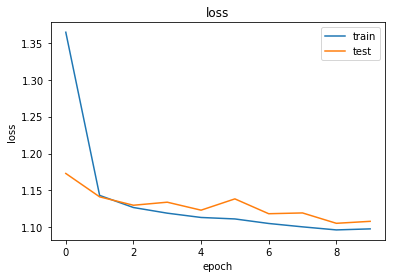

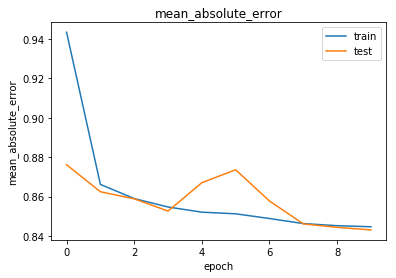

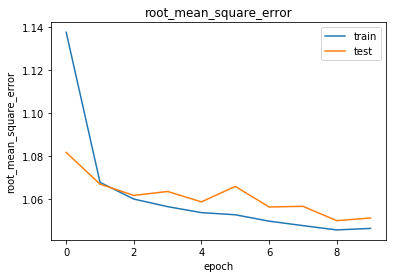

In [34]:
plot_history(history)

Evaluate the trained model on test user-movie rankings:

In [35]:
test_metrics = model.evaluate_generator(mapper_test, use_multiprocessing=True, workers=num_workers, verbose=1)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

150/150 [==============================] - 3s 22ms/step
Test Evaluation:
	loss: 1.1069
	root_mean_square_error: 1.0508
	mean_absolute_error: 0.8431


Compare the predicted test rankings with "mean baseline" rankings, to see how much better our model does compared to this (very simplistic) baseline:

In [36]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict_generator(mapper_test)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = y_pred/y_pred*np.mean(y_true)

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.1308212865975888
	mean_absolute_error =  0.9491351001421611

Model Test set metrics:
	root_mean_square_error =  1.0523022913879858
	mean_absolute_error =  0.8425556223541498


We see that our model beats the "mean baseline", although not by much. To further improve the model, you can try increasing the number of training epochs, change the dropout rate, change the sample sizes for subgraph sampling `num_samples`, hidden layer sizes `layer_sizes` of the HinSAGE part of the model, or try increasing the number of HinSAGE layers.